In [107]:
import matplotlib.font_manager as fm

# fm.fontManager.addfont("./th_sarabun.ttf")

In [109]:
fm.fontManager.ttflist

[<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>,
 <Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>,
 <Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>,
 <Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>,
 <Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>,
 <Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>,
 <Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>,
 <Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>,
 <Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>,
 <Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>,
 <Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>,
 <Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>,
 <Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>,

In [2]:
# font_prop = fm.FontProperties(fname="TH SarabunPSK", size=16)

# Introduction

- Input ...
- Visualization

- get relevance scores
  - sensitivyt analysis
  - LRP Implementation

In [4]:
import sys
print(sys.path)
import sys
sys.path.append("../") 

['/Users/pat/projects/attacut/notebooks', '/Users/pat/projects/attacut/notebooks/(pwd)', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/IPython/extensions', '/Users/pat/.ipython', '../']


In [7]:
from attacut import Tokenizer

In [168]:
import numpy as np
import torch
import torch.nn.functional as F
from attacut import Tokenizer
from matplotlib import pyplot as plt


sc_cnn = "../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13"
sc_lstm = "../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-05-16--17-57.30/run-24"
atta_sc_cnn = Tokenizer(model=sc_cnn)
atta_sc_lstm = Tokenizer(model=sc_lstm)

using bi-direction


In [9]:
sentence = "อำนาจตุลาการ คือจุดอ่อนของประชาธิปไตยไทย"

sentences = [
  sentence,
  "ความแตกต่างอีกประการหนึ่งระหว่างไทยและอินเดีย",
  "เริ่ม~มี~ผู้~โทร~ศัพท์~ขอ~รับ~คำ~ปรึก~ษา~เนื่อง~จาก~เครียด".replace("~", ""),
  "แผน~ผัง~การ~ขยาย~พันธุ์~พืช~โดย~ย่อ~ๆ".replace("~", "")
]

In [15]:
atta_sc_cnn.tokenize(sentence)

['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุดอ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [169]:
atta_sc_lstm.tokenize(sentence)

['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุดอ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [17]:
def word_boundary(model, sentence):
  words = model.tokenize(sentence)
  mask = np.zeros(len(sentence))

  cur_len = 0
  for w in words:
    mask[cur_len] = 1
    cur_len += len(w)
  return mask

word_boundary(atta_sc_cnn, sentence)

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [14]:
from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [184]:
class AttaCutSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        embedding = embedding.permute(0, 2, 1)

        conv1 = self.base.model.conv1(embedding)
        conv2 = self.base.model.conv2(conv1)
        out = self.base.model.conv3(conv2)

        out = out.permute(0, 2, 1)
        out = F.relu(self.base.model.linear1(out))
        out = self.base.model.linear2(out)

        return out

In [162]:
def interpret_atta_sc(txt, wrapper_func):
    wrapper = wrapper_func()

    def ig_attac_forward(src, idx, pred):

        return wrapper.forward(src)[:, idx, pred]

    ig_c = IntegratedGradients(ig_attac_forward)

    tokens, features = wrapper.base.dataset.make_feature(txt)
    inputs = (features, torch.Tensor(0))

    x, _, _ = wrapper.base.dataset.prepare_model_inputs(inputs, device="cpu")

    wrapper.eval()
    wrapper.zero_grad()
    
    # pre-computing word embeddings
    interpretable_ch_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'ch_embeddings')

    src_ch_indices = torch.LongTensor(x[0][:, 0, :])
    src_ch_embedding = interpretable_ch_embedding.indices_to_embeddings(src_ch_indices)
    
    src_ch_t_indices = torch.LongTensor(x[0][:, 1, :])
    src_ch_t_embedding = interpretable_ch_embedding.indices_to_embeddings(src_ch_t_indices)
    
    
    interpretable_sy_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'sy_embeddings')
    src_sy_indices = torch.LongTensor(x[0][:, 2, :])
    src_sy_embedding = interpretable_sy_embedding.indices_to_embeddings(src_sy_indices)

    ch_dims = src_ch_embedding.shape[2] + src_ch_t_embedding.shape[2]

    embedding = torch.cat([src_ch_embedding, src_ch_t_embedding, src_sy_embedding], dim=2)

    outputs = wrapper(embedding).squeeze(0)

    # # get output_tokens from outputs
    # # compute attributions and approximation delta using integrated gradients
    attribution_igs = np.zeros((len(tokens), len(tokens), 2))

    for idx in range(len(tokens)):
        pred = np.argmax(outputs[idx, :].detach().numpy())

        attribution_ig =  ig_c.attribute(
            embedding, additional_forward_args=(idx, pred),
            n_steps=10
        ).detach().numpy()

        attribution_ig = attribution_ig.squeeze()

        ch_attr, sy_attr = attribution_ig[:, :ch_dims], attribution_ig[:, ch_dims:]

        attribution_igs[:, idx, 0] = np.sum(ch_attr, axis=1)
        attribution_igs[:, idx, 1] = np.sum(sy_attr, axis=1)

    return attribution_igs

raw_attribution = interpret_atta_sc(sentence, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)))

In [ ]:
def plot_boundary(boundary):
    for i, b in enumerate(boundary):
        if b:
            plt.axvline(i, color="gray", lw=0.5, alpha=0.5)
            plt.axhline(i, color="gray", lw=0.5, alpha=0.5)

    plt.plot([0, i], [0, i], color="gray", lw=0.5, alpha=0.5)

def plot_sc_relevances(sentence, model, wrapper_func, font="Sukhumvit Set", fontsize=12, name=""):
    boundary = word_boundary(model, sentence)

    relevances = np.power(interpret_atta_sc(sentence, wrapper_func), 2)
    characters = list(sentence)

    plt.figure(figsize=(15, 5))


    # sum over all ch, sy_emb, then all contribution
    location_relevance = relevances.sum(axis=2)
    norm_ord = 2
    norm = np.linalg.norm(location_relevance, axis=0, ord=norm_ord)

    location_relevance /= norm

    ax = plt.subplot(1, 3, 1)
    plt.title(f"{name}: Total Attribution")

    np.testing.assert_allclose(np.linalg.norm(location_relevance, axis=0, ord=norm_ord), 1, err_msg="some attribution isn't normalized")


    mm = 1
    plt.imshow(location_relevance, cmap="Reds", vmin=0, vmax=mm)
    plt.colorbar()

    plt.ylabel("Contribution from Position $i$-th")

    ix = np.argwhere(boundary).reshape(-1)
    plt.yticks(ix, map(lambda i: characters[i],ix), fontname=font, fontsize=fontsize)
    plt.xticks(range(len(sentence)), list(sentence), fontname=font, fontsize=fontsize)
    plt.xlabel("Text")
    ax.tick_params(axis="x", pad=10, which='major',)
    

    plot_boundary(boundary)

#     ax = plt.subplot(1, 3, 2)
#     plt.title("Character Embeddings Attribution")

#     ch_mat = relevances[:, :, 0] / norm

#     plt.imshow(ch_mat, cmap="Reds", vmin=0, vmax=mm)
# #     plt.colorbar()


#     ix = np.argwhere(boundary).reshape(-1)
#     plt.yticks(ix, map(lambda i: characters[i],ix), fontname=font, fontsize=fontsize)
#     plt.xticks(range(len(sentence)), list(sentence), fontname=font, fontsize=fontsize)
#     ax.tick_params(axis="x", pad=10, which='major',)



#     plot_boundary(boundary)

#     ax = plt.subplot(1, 3, 3)
#     plt.title("Syllable Embedding Attribution")
#     sy_mat = relevances[:, :, 1] / norm

#     np.testing.assert_allclose(sy_mat + ch_mat, location_relevance)
#     plt.imshow(sy_mat, cmap="Reds", vmin=0, vmax=mm)

#     plot_boundary(boundary)
#     ax.tick_params(axis="x", pad=10, which='major',)


    plt.yticks(ix, map(lambda i: characters[i],ix), fontname=font, fontsize=fontsize)
    plt.xticks(range(len(sentence)), list(sentence), fontname=font, fontsize=fontsize)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_sc_relevances(sentences[-1], atta_sc_cnn, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)), name="DilatedCNN(CH+SY)")
plt.savefig("./figures/explained_cnn.png", dpi=300)

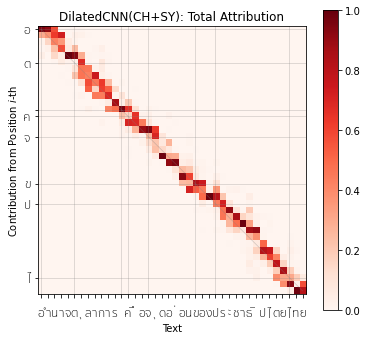

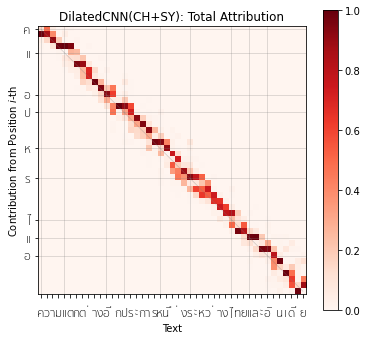

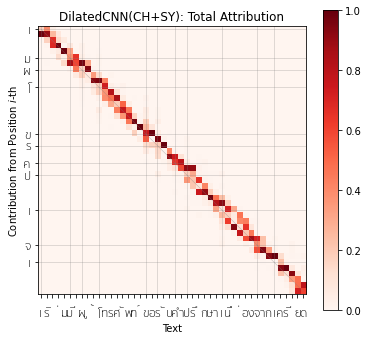

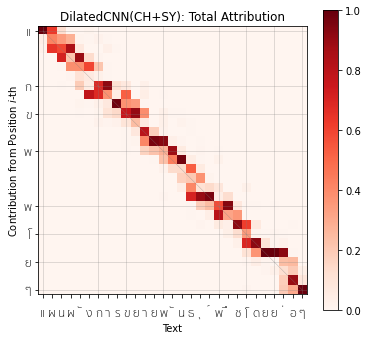

In [188]:
for s in sentences:
    plot_sc_relevances(s, atta_sc_cnn, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)), name="DilatedCNN(CH+SY)")

In [175]:
class AttaCutLSTMSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        out, _ = self.base.model.lstm(embedding.permute(1, 0, 2))

        out = out.permute(1, 0, 2)

        out = self.base.model.linear1(out)

        return out

using bi-direction


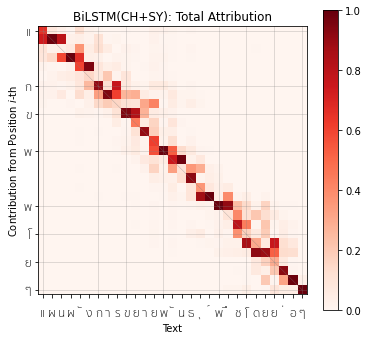

In [196]:
plot_sc_relevances(sentences[-1], atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)")
plt.savefig("./figures/explained_lstm.svg")

using bi-direction
using bi-direction
using bi-direction
using bi-direction


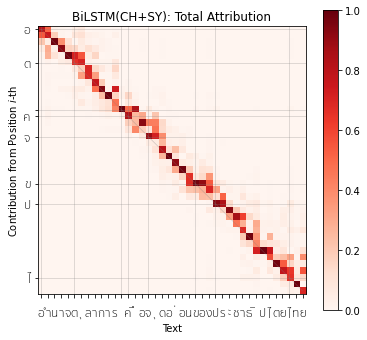

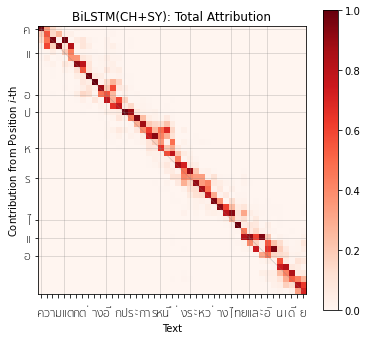

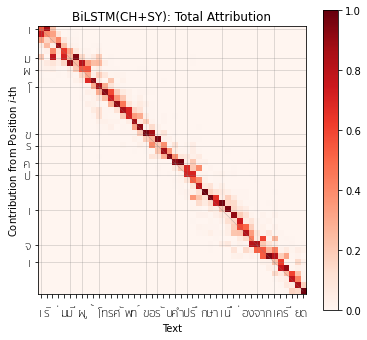

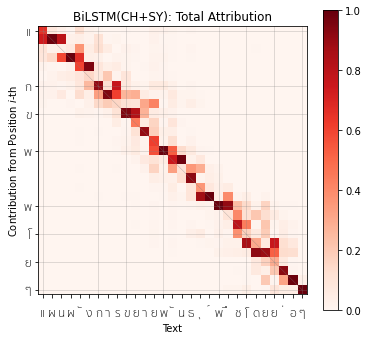

In [192]:
for s in sentences:
    plot_sc_relevances(s, atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)")

# Explain AttaCut-C

In [0]:
atta_c.

In [0]:
class AttaCutCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer
        self.emb_dim = list(self.base.model.embeddings.parameters())[0].shape[1]

    def forward(self, src_ix):
        return self.base.model((src_ix, 0))

# attac_wrapper = AttaCutCWrapper(Tokenizer(model="attacut-c"))

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


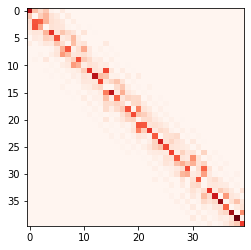

In [0]:
def interpret_atta_c(txt):
    attac_wrapper = AttaCutCWrapper(Tokenizer(model="attacut-c"))
    seq_length = len(txt)
    def ig_attac_forward(src, idx):
      return attac_wrapper.forward(src)[idx].unsqueeze(0)

    # pad_ix = 0
    # reference_emb = attac_wrapper.base.model.embeddings(
    #     torch.Tensor([pad_ix]).long()
    # ).unsqueeze(0)

    ig_c = IntegratedGradients(ig_attac_forward)

    tokens, features = attac_wrapper.base.dataset.make_feature(txt)
    inputs = (features, torch.Tensor(0))

    x, _, _ = attac_wrapper.base.dataset.prepare_model_inputs(inputs, device="cpu")
    
    attac_wrapper.eval()
    attac_wrapper.zero_grad()
    
    # pre-computing word embeddings
    interpretable_c_embedding = configure_interpretable_embedding_layer(attac_wrapper.base.model, 'embeddings')
    src_indices = torch.LongTensor(x[0])
    src_embedding = interpretable_c_embedding.indices_to_embeddings(src_indices)
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = attac_wrapper(src_embedding).squeeze(0)

    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    attribution_igs = np.zeros((len(tokens), len(tokens), attac_wrapper.emb_dim))

    # reference_indices = token_reference.generate_reference(seq_length, "cpu").unsqueeze(0)



    for idx, output in enumerate(outputs):
        attribution_ig =  ig_c.attribute(src_embedding, additional_forward_args=(idx), n_steps=10)
        attribution_igs[:, idx, :] = attribution_ig.detach().numpy()
    
    del interpretable_c_embedding
    return attribution_igs

raw_attribution = interpret_atta_c(sentence)

attribution_ig = np.sum(raw_attribution, axis=2)
normed_attribution_ig = attribution_ig/np.sum(attribution_ig, axis=0)
plt.imshow(normed_attribution_ig, cmap="Reds", vmin=0, vmax=np.max(normed_attribution_ig))

In [0]:
def plot_boundary(boundary):
  for i, b in enumerate(boundary):
    if b:
      plt.axvline(i, color="gray", lw=0.5, alpha=0.5)
      plt.axhline(i, color="gray", lw=0.5, alpha=0.5)

  plt.plot([0, i], [0, i], color="gray", lw=0.5, alpha=0.5)

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


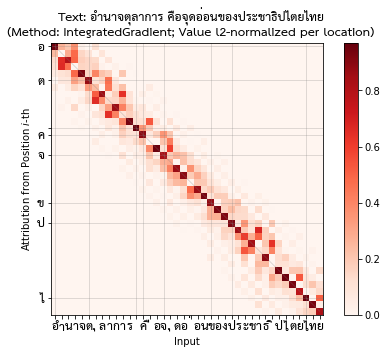

In [0]:
def plot_c_relevances(sentence):
  # we need to use a different model here because Captum will override the embedding layer
  boundary = word_boundary(atta_c, sentence)
  characters = list(sentence)

  attribution = interpret_atta_c(sentence)

  attribution = np.sum(attribution, axis=2)

  attribution = attribution/np.linalg.norm(attribution, axis=0) # normalized score per location to be one

  plt.figure(figsize=(7.5, 5))

  plt.suptitle(f"Text: {sentence}\n(Method: IntegratedGradient; Value l2-normalized per location)", fontname="TH SarabunPSK", fontsize=18)

  plt.imshow(attribution, cmap="Reds", vmin=0, vmax=np.max(attribution))
  plt.colorbar()

  plt.ylabel("Attribution from Position $i$-th")
  ix = np.argwhere(boundary).reshape(-1)
  plt.yticks(ix, map(lambda i: characters[i],ix), fontname="TH SarabunPSK", fontsize=18)
  plt.xticks(range(len(sentence)), list(sentence), fontname="TH SarabunPSK", fontsize=18, )
  plt.xlabel("Input")

  plot_boundary(boundary)

plot_c_relevances(sentence)

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


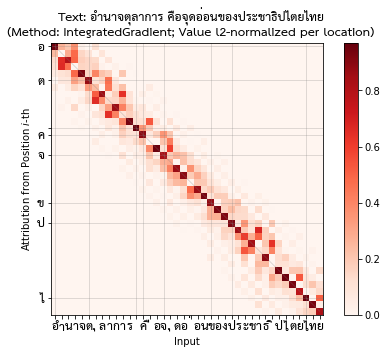

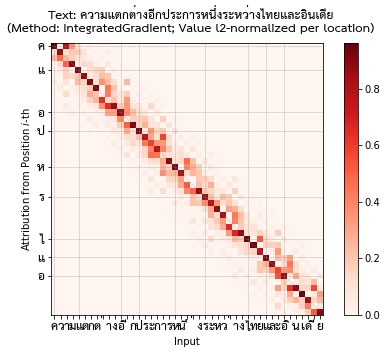

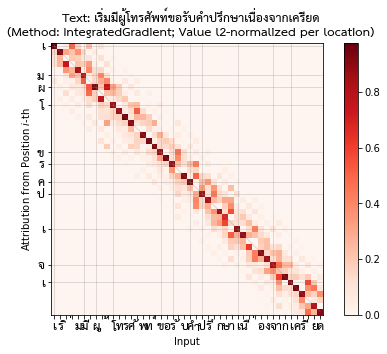

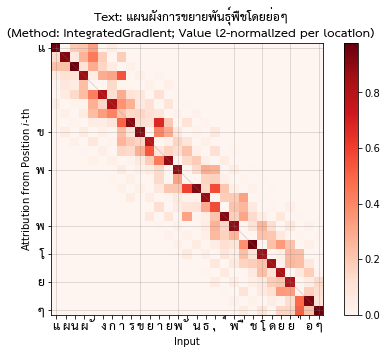

In [0]:
for s in sentences:
  plot_c_relevances(s)

# Explain AttaCut-SC

In [0]:
class AttaCutSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

        layers = list(self.base.model.parameters())

        self.emb_dim = layers[0].shape[1] \
          + layers[1].shape[1]

        self.emb_ch_dim = layers[0].shape[1]

    def forward(self, x):
        embedding = x

        embedding = embedding.permute(0, 2, 1)

        conv1 = self.base.model.conv1(embedding).permute(0, 2, 1)
        conv2 = self.base.model.conv2(embedding).permute(0, 2, 1)
        conv3 = self.base.model.conv3(embedding).permute(0, 2, 1)

        out = torch.stack((conv1, conv2, conv3), 3)

        out, _ = torch.max(out, 3)

        out = F.relu(self.base.model.linear1(out))
        out = self.base.model.linear2(out)

        return out.view(-1)

In [0]:
atta_sc.model

Model(
  (ch_embeddings): Embedding(139, 32, padding_idx=0)
  (sy_embeddings): Embedding(6227, 16, padding_idx=0)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv1): ConvolutionBatchNorm(
    (conv): Conv1d(48, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvolutionBatchNorm(
    (conv): Conv1d(48, 64, kernel_size=(5,), stride=(1,), padding=(6,), dilation=(3,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvolutionBatchNorm(
    (conv): Conv1d(48, 64, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


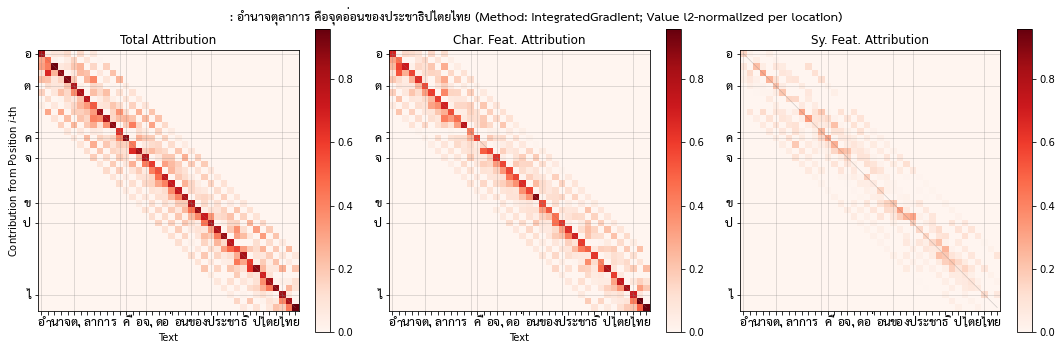

In [0]:
def plot_sc_relevances(sentence):
  boundary = word_boundary(atta_sc, sentence)

  relevances = interpret_atta_sc(sentence)
  
  characters = list(sentence)

  plt.figure(figsize=(15, 5))


  # sum over all ch, sy_emb, then all contribution
  location_relevance = relevances.sum(axis=2)
  norm_ord = 2
  norm = np.linalg.norm(location_relevance, axis=0, ord=norm_ord)
  location_relevance /= norm

  ax = plt.subplot(1, 3, 1)
  plt.title("Total Attribution")

  np.testing.assert_allclose(np.linalg.norm(location_relevance, axis=0, ord=norm_ord), 1, err_msg="some attribution isn't normalized")

  
  mm = np.max(location_relevance)
  plt.imshow(location_relevance, cmap="Reds", vmin=0, vmax=mm)
  plt.colorbar()

  plt.ylabel("Contribution from Position $i$-th")

  ix = np.argwhere(boundary).reshape(-1)
  plt.yticks(ix, map(lambda i: characters[i],ix), fontname="TH SarabunPSK", fontsize=18)
  plt.xticks(range(len(sentence)), list(sentence), fontname="TH SarabunPSK", fontsize=18)
  plt.xlabel("Text")

  plot_boundary(boundary)

  ax = plt.subplot(1, 3, 2)
  plt.title("Char. Feat. Attribution")

  ch_mat = relevances[:, :, 0] / norm

  plt.imshow(ch_mat, cmap="Reds", vmin=0, vmax=mm)
  plt.colorbar()


  ix = np.argwhere(boundary).reshape(-1)
  plt.yticks(ix, map(lambda i: characters[i],ix), fontname="TH SarabunPSK", fontsize=18)
  plt.xticks(range(len(sentence)), list(sentence), fontname="TH SarabunPSK", fontsize=18)
  plt.xlabel("Text")

  plot_boundary(boundary)

  plt.subplot(1, 3, 3)
  plt.title("Sy. Feat. Attribution")
  sy_mat = relevances[:, :, 1] / norm

  np.testing.assert_allclose(sy_mat + ch_mat, location_relevance)
  plt.imshow(sy_mat, cmap="Reds", vmin=0, vmax=mm)

  plt.colorbar()
  plt.suptitle(f": {sentence} (Method: IntegratedGradient; Value l2-normalized per location)", fontname="TH SarabunPSK", fontsize=18)
  plot_boundary(boundary)

  plt.yticks(ix, map(lambda i: characters[i],ix), fontname="TH SarabunPSK", fontsize=18)
  plt.xticks(range(len(sentence)), list(sentence), fontname="TH SarabunPSK", fontsize=18)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_sc_relevances(sentence)

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


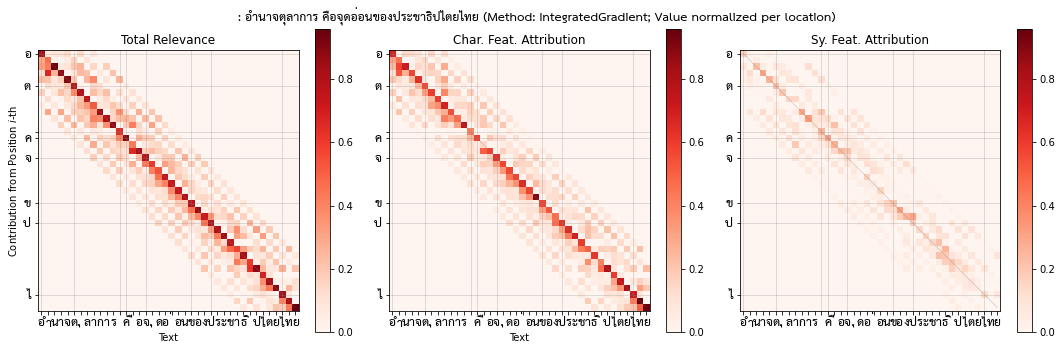

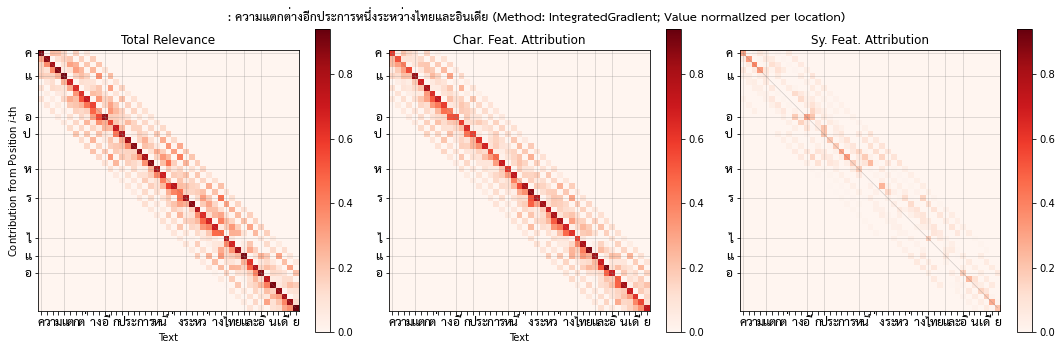

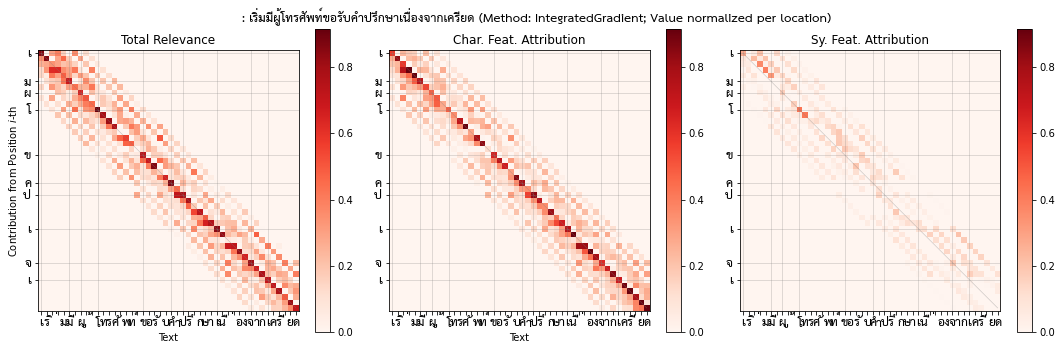

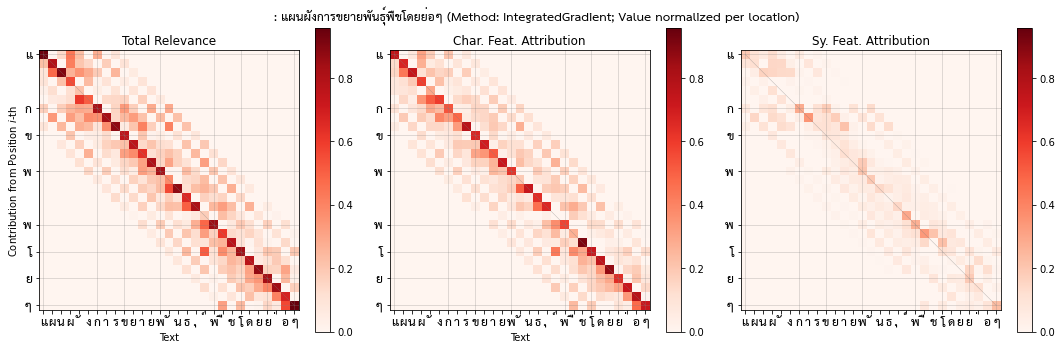

In [0]:
for s in sentences:
  plot_sc_relevances(s)

In [0]:
list("ปี")

In [0]:
"".join(list("ป_ี")[1:])

In [0]:
characters = list(sentence)

In [0]:
# characters

In [0]:
total = len(characters)
cc = np.array(range(total)).reshape((-1, 1))
source = (np.tile(cc, total).reshape(-1) + total).tolist()
target_ = np.tile(cc, total).T.reshape(-1) 
# target = np.concatenate((target_, target_ + total))

In [0]:
def prefix_label(label, prefix):
  return list(map(lambda x: f"{prefix} {x}", label))

In [0]:
import plotly.graph_objects as go

def visualize_relevance(relevance):
  fig = go.Figure(data=[go.Sankey(
      hoverinfo  = "none",
      node = dict(
        pad = 5,
        thickness = 10,
        line = dict(color = "black"),
        label = prefix_label(characters, "Ch-EMB: ") + prefix_label(characters, "Token: ") + prefix_label(characters, "Sy-EMB: "),
        color = "red"
      ),
      link = dict(
          color  = "rgba(100, 100, 100, 0.05)", 
        # line =  dict(color="black"),
        source = target_.tolist() + source,
        target = source+(target_+2*total).tolist(),
        value = relevances[:, :, 0].reshape(-1).tolist() + relevances[:, :, 1].reshape(-1).tolist()
    ))])

  fig.update_layout(title_text=f"Relevance Feature: {sentence}", font_size=10)
  fig.show()
visualize_relevance(relevances)

In [0]:
 target_

In [0]:
lens = torch.Tensor([5, 2, 3])
max_len = torch.max(lens)
(torch.arange(max_len).expand(lens.shape[0], max_len) < lens.unsqueeze(1)).type(torch.uint8)


In [0]:
logits